## Graphene/BN stack diffusion simulation

### Potential Surface

First we define the potential energy surface described for a graphene/hBN stack as described by the section **Parametrization of potential energy** of *Origin of band gaps in graphene on hexagonal boron nitride* (Jung et. al.)

Potential can be written as (eq. 28):

$$\Phi(x, y, C_0, C_1, \phi) = C_0 + 2C_1 \cos(\phi-G_1y) + 4C_1 \cos(G_1y/2 + \phi)\cos(\sqrt{3}G_1x / 2)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

lattice_constant_mismatch = 0.03
lattice_angle_mismtach = 0 * np.pi / 180 # degrees to radians
# Moire superlattice wavelength, in units of graphene lattice constant length
# lm = (lattice_constant_mismatch ** 2 + lattice_angle_mismtach ** 2) ** (-1/2)
lm = 45
# G1 = 4 * np.pi / (np.sqrt(3) * lm)
G1 = 1e-1

f1 = lambda x, y, C1, phi: 2 * C1 * np.cos(phi - G1 * y) \
    + 4 * C1 * np.cos(G1 * y/2 + phi) * np.cos(np.sqrt(3)*G1 * x /2)

def Phi(C0, C1, phi):
    """
    Returns a function U(x, y) that evaluates to Phi(x, y; C0, C1, phi)
    Lattice constant defaults to graphene lattice constant in nanometers (nm)
    """
    return lambda x, y : C0 + f1(x, y, C1, phi)

# Define constants
M0, tau, D0, T0, T1, phi = 0.06975, 7, 3.46, -10.44, -58.87, 50.4 / 180 * np.pi
M = lambda x : -M0 * (1 + tau * x) * np.exp(-tau * x)
T = lambda x : T0 / (x ** 4 + T1)
W = lambda x : (1 + np.exp(-16 * (x - 4))) ** -1
C0 = lambda z : (M(z / D0 - 1) + (T(z) - M(z / D0 - 1)) * W(z))
z = 3.4 # Angstroms
C0 = C0(z)

a, b, z0  = 2.226, 3.295, 1.295
C1 = lambda z : a * np.exp(-b * (z - z0))
C1 = C1(z)

Uc = Phi(C0 / 2, C1, phi)
print("Moire lattice constant lm = {}".format(lm))
print("Moire reciprocaal lattice constant G1 = {}".format(G1))

Moire lattice constant lm = 45
Moire reciprocaal lattice constant G1 = 0.1


(-20, 20)

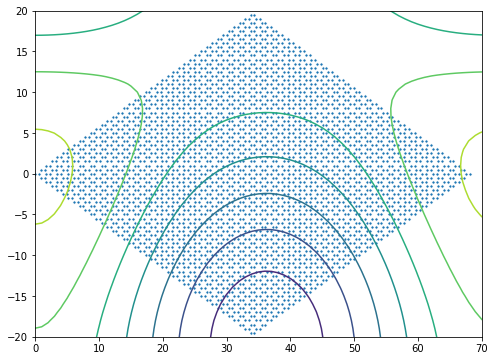

In [2]:
import seaborn as sns
lattice = []
atom_a = np.array([0, 0])
atom_b = np.array([1/np.sqrt(3), 0])
a1 = np.array([np.sqrt(3)/2, 1/2])
a2 = np.array([np.sqrt(3)/2, -1/2])
for i in range(40):
    for j in range(40):
        cell_origin = i * a1 + j * a2
        lattice.append(cell_origin + atom_a)
        lattice.append(cell_origin + atom_b)
lattice = np.array(lattice)
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(lattice[:,0], lattice[:, 1], s=10)
delta = 1
x = np.arange(-75, 75, delta)
y = np.arange(-75, 75, delta)
X, Y = np.meshgrid(x, y)
Z = Uc(X, Y)
CS = ax.contour(X, Y, Z)
plt.xlim(-0, 70)
plt.ylim(-20, 20)

In [3]:
def to_real_space(particles):
    real_space = np.empty(shape=(N, 2))
    for j in range(2):
        real_space[:, j] = particles[:, 0] * a1[j] + particles[:, 1] * a2[j] + neighbor_dist[j] * particles[:, 2]
    return real_space

In [4]:
N = 500
num_jumps = 10000
U_max = Uc(0, 0)
np.random.seed(0)
muls = 2.125e-1
U = lambda r : U_max - Uc(r[:, 0], r[:, 1])
T = (np.max(Z) - np.min(Z)) * muls # Temperature
neighbor_dist = np.array([1/np.sqrt(3), 0])

a_transition = np.array([
    [0, 0, 1],
    [-1, 0, 1],
    [0, -1, 1],
], dtype=np.int)
b_transition = np.array([
    [0, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
], dtype=np.int)

# Initial point source of N particles at origin
# particles = np.tile(np.array([0, 20, 0], dtype=np.int), (N, 1))
particles = np.concatenate((np.random.randint(-100, 100, size=(N, 2), dtype=np.int), 
                      np.zeros((N, 1))), axis=1)
wait_times = np.zeros((num_jumps + 1, N))
tracks = np.array([particles.copy()])
for t in range(1, num_jumps + 1):
    if t % (num_jumps / 10) == 0:
        print("{} % done".format(100 * t / num_jumps))
    # Draw waiting time
    escape_rate = np.exp(-U(to_real_space(particles)) / T)
    wait_times[t] = np.random.exponential(1 / escape_rate, size=N) # numpy does scale parameter instead of rate
#     wait_times[t] = np.random.pareto(0.5, size=N)
#     wait_times[t] = np.ones(N)
    # Draw jump direction
    jump_direction = np.random.randint(3, size=N)
    jumps = a_transition[jump_direction] if t % 2 == 1 else b_transition[jump_direction]
    particles[:, :2] += jumps[:, :2]
    particles[:, 2] = jumps[:, 2]
    tracks = np.append(tracks, particles.copy()[np.newaxis, :], axis=0)

10.0 % done
20.0 % done
30.0 % done
40.0 % done
50.0 % done
60.0 % done
70.0 % done
80.0 % done
90.0 % done
100.0 % done


In [5]:
tracks.shape

(10001, 500, 3)

In [6]:
wait_times.shape

(10001, 500)

In [7]:
tX.shape

NameError: name 'tX' is not defined

In [ ]:
from scipy.interpolate import interp1d
end_time = 10000
num_pts = 10000
tX = np.cumsum(wait_times, axis=0)
tX = tX / np.max(tX, axis=0) * end_time
tOut = np.arange(0, num_pts + 1, 1) * end_time / num_pts
real_space_tracks = np.empty(shape=(N, num_pts + 1, 2))
for i in range(N):
    for j in range(2):
        tmp = tracks[:, i, 0] * a1[j] + tracks[:, i, 1] * a2[j] + neighbor_dist[j] * tracks[:, i, 2]
        real_space_tracks[i, :, j] = interp1d(tX[:, i], tmp, 
                                         kind='previous', 
                                         bounds_error=False)(tOut)

In [ ]:
tX

In [ ]:
tOut

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.scatter(real_space_tracks[0][:,0],real_space_tracks[0][:,1], s=2)
delta = 0.1
x = np.arange(-40, 40, delta)
y = np.arange(-40, 40, delta)
X, Y = np.meshgrid(x, y)
Z = Uc(X, Y)
CS = ax.contour(X, Y, Z)

In [716]:
import pandas as pd
df = pd.DataFrame()
for particle in range(N):
    tmp = pd.DataFrame(real_space_tracks[particle], columns=['x', 'y'])
    tmp['particle'] = particle
    tmp['time'] = tOut
    tmp['r^2'] = (tmp['x'] - tmp['x'].iloc[0]) ** 2 + (tmp['y'] - tmp['y'].iloc[0]) ** 2
    df = pd.concat([df, tmp])
df.head()

,x,y,particle,time,r^2
0,16.454483,62.5,0,0.0,0.000000
1,17.320508,62.0,0,1.0,1.000000
2,17.031833,62.5,0,2.0,0.333333
3,17.031833,62.5,0,3.0,0.333333
4,17.031833,62.5,0,4.0,0.333333


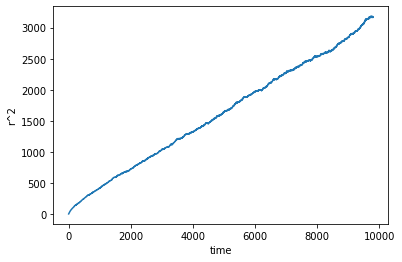

In [717]:
import seaborn as sns
# sns.lineplot(x='time', y='r^2', hue='particle', data=df, alpha=0.1)
sns.lineplot(x='time', y='r^2', data=df.groupby('time').mean().reset_index()[:-200])

In [718]:
from scipy.stats import linregress
tmp = df.groupby('time').mean().reset_index().iloc[:-200]
t, r_squared = tmp['time'], tmp['r^2']
r_squared = np.log(r_squared[1:-1]).replace([np.inf, -np.inf], np.nan).dropna()
slope, intercept, _, _, _ = linregress(np.log(r_squared.index)[:-200], r_squared[:-200])

In [719]:
slope

0.8309767117479311

In [720]:
# jointplot = sns.jointplot(x='x', y='y', data=df, kind='hex', color='k',
#                          joint_kws = {'gridsize' : (300, 300)})
# x = np.arange(-100, 100, delta)
# y = np.arange(-100, 100, delta)
# X, Y = np.meshgrid(x, y)
# Z = Uc(X, Y)
# CS = jointplot.ax_joint.contour(X, Y, Z, alpha=0.2)
# jointplot.ax_joint.figure.set_size_inches(8, 8)
# jointplot.ax_joint.figure.set_dpi(200)
# jointplot.ax_joint.set_xlim(-100, 100)
# jointplot.ax_joint.set_ylim(-100, 100)

In [ ]:
Gs.append(G1)
Ts.append(muls)

In [ ]:
print(Gs)
print(Ts)

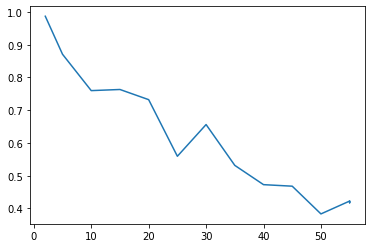

In [567]:
plt.plot(lms, slopes)

Text(0, 0.5, 'frequency')

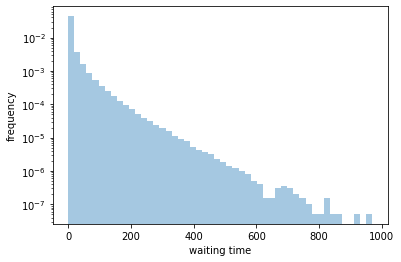

In [18]:
from scipy.stats import expon, pareto
from scipy.special import erfcx
ax = sns.distplot(wait_times[:2000].ravel(), kde=False, norm_hist=True, hist_kws={'log':True})
# sns.distplot(wait_times.ravel(), fit=expon, kde=False, ax=ax, norm_hist=True)
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel('waiting time')
ax.set_ylabel('frequency')

In [602]:
pareto.fit(wait_times.ravel()[wait_times.ravel() > 1e0])

(0.26901057048766375, -0.0005262874630390119, 1.000530990257884)

Moire pattern size, moire potential height, temperature

Text(0, 0.5, 'frequency')

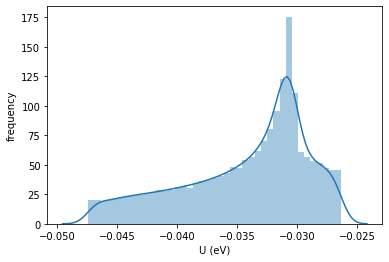

In [25]:
sns.distplot(Z.ravel())
plt.xlabel("U (eV)")
plt.ylabel("frequency")


(0, 1)

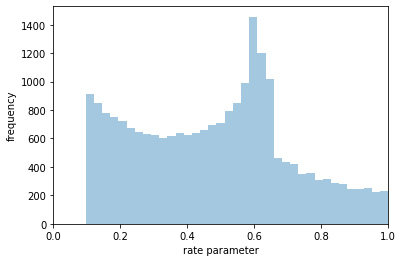

In [59]:
sns.distplot(np.exp(-(U_max - Z.ravel()) / 9e-3), kde=False)
plt.xlabel("rate parameter")
plt.ylabel("frequency")
plt.xlim(0, 1)